In [207]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [208]:
def getTables(url,index=0):
    tables = pd.read_html(url)
    df = tables[index]
    return df

def earliest_estimate_gdp_ppp(row):
    # Extract the years and estimates from the row
    data = [
        (row[('IMF[4][5]', 'Year')],       row[('IMF[4][5]', 'Projection')]),   # Note: is it 'Forecast' or 'Estimate'? Adjust if needed!
        (row[('World Bank[6]', 'Year')],   row[('World Bank[6]', 'Estimate')]),
        (row[('CIA[7][8][9]', 'Year')], row[('CIA[7][8][9]', 'Estimate')]),
    ]
    # Filter out missing years/estimates
    data = [(y, e) for (y, e) in data if pd.notnull(y) and pd.notnull(e) and y != "—"]
    if not data:
        return np.nan
    # Find the minimum year
    min_year, estimate = min(data, key=lambda x: int(getYear(x[0])))
    return estimate

def earliest_estimate_gdp_per_cap(row):
    # Extract the years and estimates from the row
    data = [
        (row[('IMF[4][5]', 'Estimate')],       row[('IMF[4][5]', 'Estimate')]),   # Note: is it 'Forecast' or 'Estimate'? Adjust if needed!
        (row[('World Bank[6]', 'Year')],   row[('World Bank[6]', 'Estimate')]),
        (row[('United Nations[7]', 'Year')], row[('United Nations[7]', 'Estimate')]),
    ]
    # Filter out missing years/estimates
    data = [(y, e) for (y, e) in data if pd.notnull(y) and pd.notnull(e) and y != "—"]
    if not data:
        return np.nan
    # Find the minimum year
    min_year, estimate = min(data, key=lambda x: int(getYear(x[0])))
    return estimate

#some years contain footnotes before them in the gdp dataset
def getYear(year):
    entries = str(year).split('[')
    if len(entries) < 2:
        return str(year).strip()
    else:
        return str(year).split(']')[1].strip()

householdExpenditure = getTables("https://en.wikipedia.org/wiki/List_of_countries_by_household_final_consumption_expenditure_per_capita")
gdp_ppp = getTables("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita", index=1)
gdpPerCapita = getTables("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita", index=1)
murderRate = getTables("https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate", index=1)

# Clean up the dataframes
householdExpenditure.rename(columns={'Country or territory': 'Country',householdExpenditure.columns[1]: 'Household expenditure'}, inplace=True)
householdExpenditure.drop(columns=["Year"], inplace=True)

gdp_ppp.rename(columns={'Country/Territory': 'Country'}, inplace=True)
gdp_ppp['GDP PPP Est'] = gdp_ppp.apply(earliest_estimate_gdp_ppp, axis=1)
gdp_ppp = gdp_ppp[['Country', 'GDP PPP Est']]
gdp_ppp.columns = gdp_ppp.columns.get_level_values(0)
gdp_ppp = gdp_ppp[gdp_ppp['Country'] != 'World']
gdp_ppp["GDP PPP Est"] = pd.to_numeric(gdp_ppp["GDP PPP Est"])
gdp_ppp['Country'] = gdp_ppp["Country"].str.replace(" *","")

gdpPerCapita.rename(columns={'Country/Territory': 'Country'}, inplace=True)
gdpPerCapita['GDP Per Cap Est'] = gdpPerCapita.apply(earliest_estimate_gdp_per_cap, axis=1)
gdpPerCapita = gdpPerCapita[['Country', 'GDP Per Cap Est']]
gdpPerCapita.columns = gdpPerCapita.columns.get_level_values(0)
gdpPerCapita = gdpPerCapita[gdpPerCapita['Country'] != 'World']
gdpPerCapita["GDP Per Cap Est"] = pd.to_numeric(gdpPerCapita["GDP Per Cap Est"])

murderRate.rename(columns={'Location': 'Country'}, inplace=True)
# remove note markers from the country names
murderRate['Country'] = murderRate["Country"].str.replace(" *","")
murderRate['Country'] = murderRate["Country"].str.replace(". England and Wales","")
murderRate.drop(columns=["Year", "Count"], inplace=True)

With the data collected and cleaned, we can join all the tables

In [209]:
#join all the tables on the country field
allData = pd.merge(householdExpenditure, gdp_ppp, on='Country', how='outer')
allData = pd.merge(allData, gdpPerCapita, on='Country', how='outer')
allData = pd.merge(allData, murderRate, on='Country', how='outer').rename(columns={'Rate': 'Murder rate'})

# remove rows with missing data
allData = allData.dropna(subset=['Household expenditure', 'GDP PPP Est', 'GDP Per Cap Est', 'Murder rate'])

display(allData)

,Country,Household expenditure,GDP PPP Est,GDP Per Cap Est,Murder rate,Region,Subregion
1,Albania,8970.0,14500.0,8575.0,1.387,Europe,Southern Europe
2,Algeria,5040.0,11000.0,5364.0,1.161,Africa,Northern Africa
5,Angola,2986.0,5900.0,2308.0,4.102,Africa,Sub-Saharan Africa
7,Antigua and Barbuda,10447.0,19100.0,21787.0,10.665,Americas,Latin America and the Caribbean
8,Argentina,13572.0,21500.0,14188.0,4.309,Americas,Latin America and the Caribbean
...,...,...,...,...,...,...,...
243,Uzbekistan,5297.0,7700.0,2850.0,1.405,Asia,Central Asia
244,Vanuatu,1708.0,2800.0,3515.0,0.321,Oceania,Melanesia
246,Vietnam,5616.0,10600.0,4282.0,1.537,Asia,South-eastern Asia
249,Zambia,1583.0,3200.0,1332.0,5.250,Africa,Sub-Saharan Africa


tSNE Time!

,index,Country,Household expenditure,GDP PPP Est,GDP Per Cap Est,Murder rate,Region,Subregion,pca-one,pca-two,pca-three
0,1,Albania,-0.389818,-0.440650,-0.475036,-0.479987,Europe,Southern Europe,-0.619346,-0.645730,0.040179
1,2,Algeria,-0.834147,-0.593572,-0.597687,-0.503760,Africa,Northern Africa,-1.014562,-0.763205,-0.217498
2,5,Angola,-1.066374,-0.816400,-0.714418,-0.194403,Africa,Sub-Saharan Africa,-1.408238,-0.537317,-0.277567
3,7,Antigua and Barbuda,-0.222827,-0.239668,0.029627,0.495944,Americas,Latin America and the Caribbean,-0.359976,0.431106,-0.114328
4,8,Argentina,0.130489,-0.134807,-0.260634,-0.172629,Americas,Latin America and the Caribbean,-0.110605,-0.210471,0.271669
...,...,...,...,...,...,...,...,...,...,...,...
139,243,Uzbekistan,-0.805090,-0.737755,-0.693715,-0.478094,Asia,Central Asia,-1.140775,-0.767199,-0.101867
140,244,Vanuatu,-1.210866,-0.951844,-0.668314,-0.592117,Oceania,Melanesia,-1.445094,-0.949242,-0.380293
141,246,Vietnam,-0.769024,-0.611048,-0.639017,-0.464209,Asia,South-eastern Asia,-1.021228,-0.725539,-0.138349
142,249,Zambia,-1.224999,-0.934368,-0.751699,-0.073647,Africa,Sub-Saharan Africa,-1.612359,-0.459861,-0.350872


Explained variation per principal component: [0.72574468 0.22219437 0.03887019]
Weights for each metric's contribution to nth PC
['Household expenditure', 'GDP PPP Est', 'GDP Per Cap Est', 'Murder rate']
[[ 0.55082105  0.5700514   0.56190046 -0.23644331]
 [ 0.1267166   0.11320427  0.16943351  0.97078318]
 [ 0.81987685 -0.31698685 -0.47660146  0.01312808]]


C:\Users\muthe\AppData\Local\Temp\ipykernel_161820\2562873724.py:27: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  p1 = sns.scatterplot(


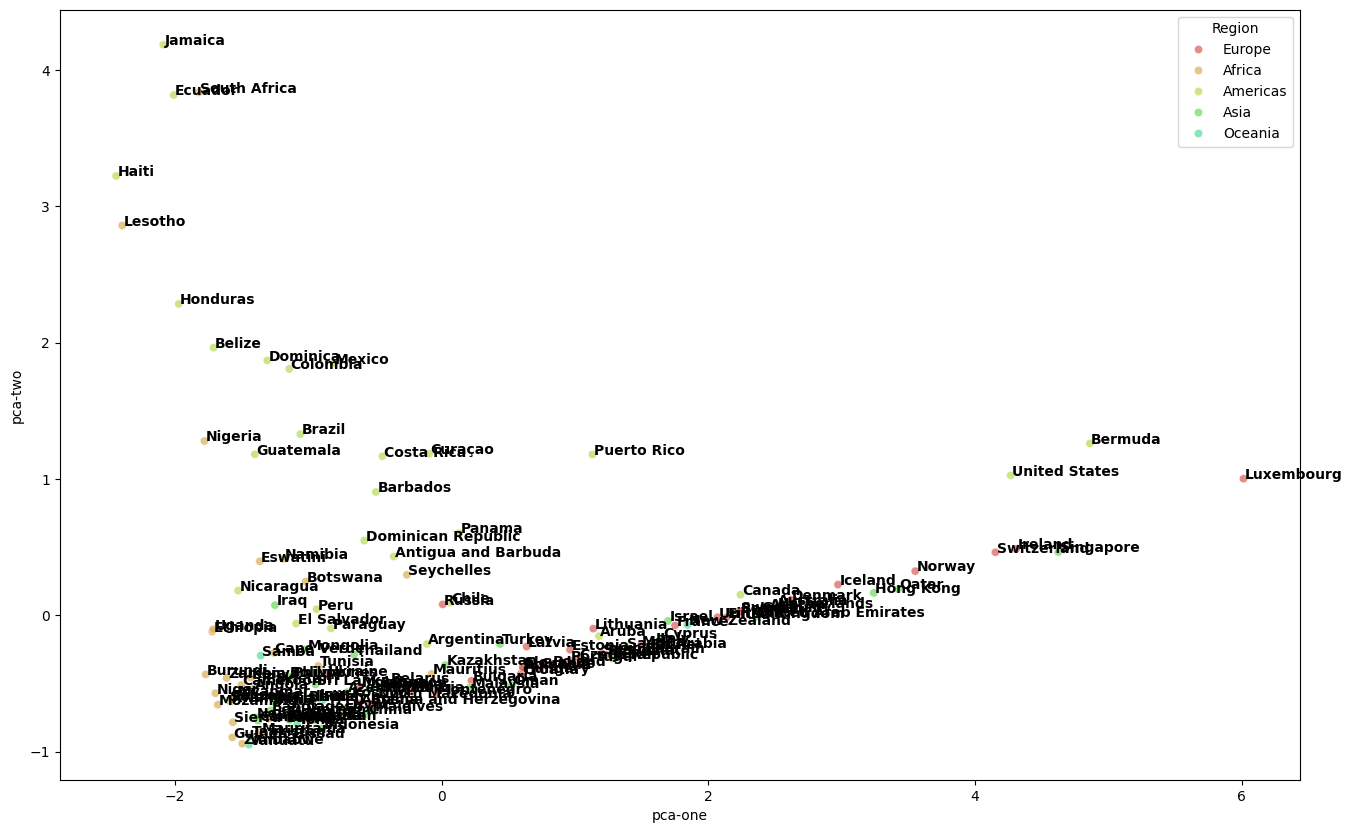

In [ ]:
#normalize the data
dataNormed = allData.copy().reset_index()
feat_cols = ["Household expenditure","GDP PPP Est","GDP Per Cap Est","Murder rate"]
for column in feat_cols:
    dataNormed[column] = (dataNormed[column] - dataNormed[column].mean()) / dataNormed[column].std()



pca = PCA(n_components=3)
pca_result = pca.fit_transform(dataNormed[feat_cols].values)

dataNormed['pca-one'] = pca_result[:,0]
dataNormed['pca-two'] = pca_result[:,1] 
dataNormed['pca-three'] = pca_result[:,2]

display(dataNormed)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print("Weights for each metric's contribution to nth PC")
print(feat_cols)
print(pca.components_)


plt.figure(figsize=(16,10))
p1 = sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=dataNormed,
    hue=dataNormed["Region"],
    legend="full",
    alpha=0.7
)
for line in range(0,dataNormed.shape[0]):
     p1.text(dataNormed["pca-one"][line]+0.01, dataNormed["pca-two"][line], 
     dataNormed["Country"][line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')